In [2]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Activation, Input, concatenate, BatchNormalization 
from keras.layers import Conv3D, UpSampling3D, Conv3DTranspose, MaxPooling3D,AveragePooling3D,GlobalAveragePooling3D, MaxPooling2D, GlobalAveragePooling2D, Conv2D
from keras.layers import add
from keras.layers import LeakyReLU, Reshape, Lambda
from keras.initializers import RandomNormal
from keras.layers import LayerNormalization, MultiHeadAttention, Dropout
from keras.layers import Flatten
from keras.layers import Dense
from tensorflow import keras
import numpy as np
import os 

Init Plugin
Init Graph Optimizer
Init Kernel


## 3D CNN 

In [31]:

def myConv3D(x_in, nf, strides=1, kernel_size = 3):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    x_out = Conv3D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out


def S3D_CNN(vol_size):
    print(vol_size)
    inputs = Input(shape=vol_size)
    layer = myConv3D(inputs, nf = 32)  
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer)
    layer = myConv3D(layer, nf =128)
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer)  
    layer = myConv3D(layer, nf= 256)
    layer = MaxPooling3D(pool_size= (3,3,3),strides=2)(layer) 
    layer = myConv3D(layer, nf= 512)
    layer = MaxPooling3D(pool_size= (5,5,5),strides=2)(layer)
    layer = GlobalAveragePooling3D()(layer)
    layer = Dense(512, activation='relu')(layer)
    layer = Dense(128, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)
    x = Dense(1,activation="sigmoid")(layer)
    #x = Activation('sigmoid')(layer)
   # x = Activation('softmax', name='softmax')(layer)
        
    model = Model(inputs=[inputs], outputs=[x])
    return model


In [2]:
S3DCNNModel = S3D_CNN((128,128,128,1))
S3DCNNModel.summary()

NameError: name 'S3D_CNN' is not defined

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")
x_test = np.load("x_test.npy")
y_test =np.load("y_test.npy")

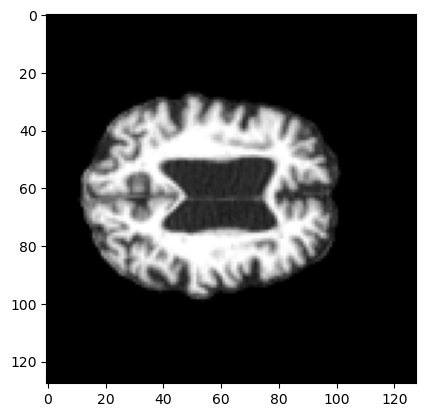

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0,:, :,80],cmap='gray')
plt.show()

# Augumenting Data

In [23]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    return volume, label


def test_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    return volume, label



def get_rotated_data(volume):

    rotated_data = tf.Variable(volume)


    sagittal_view = tf.transpose(rotated_data, perm=[0, 2, 3, 1, 4])
    coronal_view = tf.transpose(rotated_data, perm=[0, 1, 3, 2, 4])
    axial_view = tf.transpose(rotated_data, perm=[0, 1, 2, 3, 4])

    return coronal_view, sagittal_view, axial_view

In [35]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 4
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
test_dataset = (
    test_loader.shuffle(len(x_test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [36]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
S3DCNNModel.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "S3D_CNN.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
S3DCNNModel.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)
    

Epoch 1/100


AssertionError: Concurrent access?

In [37]:
# Load best weights.
S3DCNNModel.load_weights("S3D_CNN.h5")
prediction = S3DCNNModel.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["CN", "AD"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

OSError: Unable to open file (unable to open file: name = 'S3D_CNN.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
preds_test = []
for i in range(0, len(x_test)):
    preds_test.append(S3DCNNModel.predict(np.expand_dims(x_test[i], axis=0))[0][0])


In [ ]:
predictionlist = [1 if x>0.5 else 0 for x in preds_test]

In [ ]:
groundtruthlist = y_test.tolist()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(groundtruthlist, predictionlist)

Confusion matrix, without normalization
[[31  0]
 [ 9 12]]


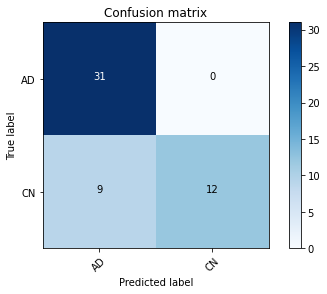

In [ ]:
plot_confusion_matrix(cm,classes=["AD","CN"])

In [ ]:
from sklearn.metrics import f1_score, precision_score,recall_score
print(f1_score(groundtruthlist, predictionlist, average='macro'))
print(precision_score(groundtruthlist, predictionlist,pos_label=1))
print(precision_score(groundtruthlist, predictionlist,pos_label=0))
print(recall_score(groundtruthlist, predictionlist,pos_label=1))
print(recall_score(groundtruthlist, predictionlist,pos_label=0))

0.8002560819462228
1.0
0.775
0.5714285714285714
1.0


## 2D MultiView Slice CNN

In [ ]:

def myConv2DBlock(x_in, nf, strides=1, kernel_size = 3):
    """
    specific convolution module including convolution followed by leakyrelu
    """
    x_out = Conv2D(nf, kernel_size=3, padding='same',kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = BatchNormalization()(x_out)
    x_out = LeakyReLU(0.2)(x_out)
    x_out = MaxPooling2D(pool_size= (2,2),strides=2)(x_out)
    return x_out

# it looks like we will have many Slice level sub-networks so we can easily use a for loop to create as many as needed using this function
def S2D_CNN_SLICE_SUB_NETWORK(vol_size):
    inputs = Input(shape=(vol_size[1:]))
    layer = myConv2DBlock(inputs, nf = 8)  
    layer = myConv2DBlock(layer, nf = 32)
    layer = myConv2DBlock(layer, nf = 64)
    layer = myConv2DBlock(layer, nf = 128)
    layer = GlobalAveragePooling2D()(layer)
    model = Model(inputs=[inputs], outputs=[layer])
        
    return model

# create netowork for a specific view
def S2D_CNN_NETWORK(vol_size):


    num_slices = vol_size[0]
    slice_networks = []
    slice_inputs = []
    for i in range(num_slices):
        slice_network = S2D_CNN_SLICE_SUB_NETWORK(vol_size)
        slice_networks.append(slice_network)
        slice_inputs.append(slice_network.inputs[0])
    layer = concatenate([slice_network.outputs[0] for slice_network in slice_networks])
    layer = Dense(128, activation='relu')(layer)
    model = Model(inputs=slice_inputs, outputs=layer)

    return model  


testModel = S2D_CNN_NETWORK((5,128,128,1))
keras.utils.plot_model(testModel, show_shapes=True)

## getting our rotated data


(237, 128, 128, 128, 1)
Coronal View


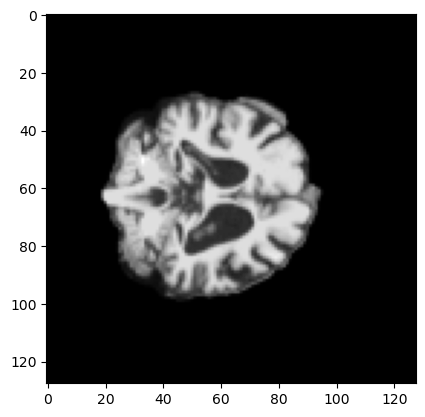

Saggital View


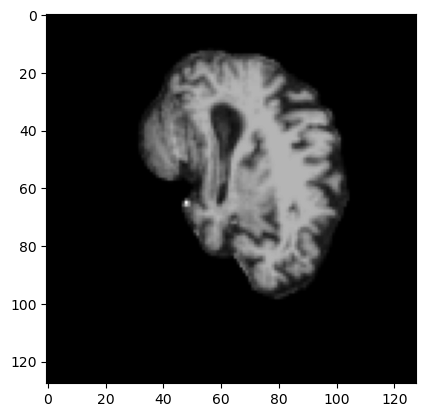

Axial View


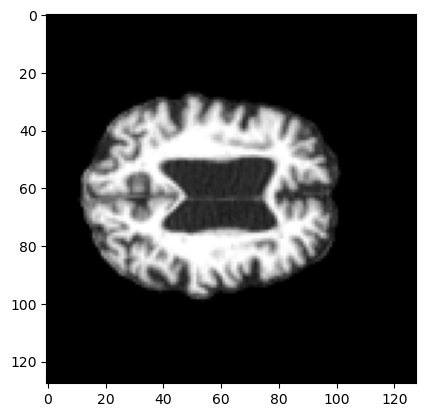

In [31]:
import matplotlib.pyplot as plt
#coronal saggital axial

coronal_train, saggital_train, axial_train = get_rotated_data(x_train)
print(coronal_train.shape)

print("Coronal View")
plt.imshow(coronal_train[3,:, :,50],cmap='gray')
plt.show()


print("Saggital View")
plt.imshow(saggital_train[0,:, :,80],cmap='gray')
plt.show()

print("Axial View")
plt.imshow(axial_train[0,:, :,80],cmap='gray')
plt.show()



In [5]:
x_train_reduced = x_train[0:10]
y_train_reduced = y_train[0:10]
print(y_train_reduced.shape)
print(x_train_reduced.shape)


x_val_reduced = x_val[0:10]
y_val_reduced = y_val[0:10]
print(y_val_reduced.shape)
print(x_val_reduced.shape)

(10,)
(10, 128, 128, 128, 1)
(10,)
(10, 128, 128, 128, 1)


## Transformer portion

In [35]:
import tensorflow as tf

# Define the transformer encoder layer
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, num_heads, ff_dim, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dense1 = tf.keras.layers.Dense(ff_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        attn_output = self.multi_head_attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ff_output = self.dense1(out1)
        ff_output = self.dense2(ff_output)
        ff_output = self.dropout2(ff_output, training=training)
        out2 = self.layernorm2(out1 + ff_output)

        return out2

# Define the model architecture
def transformer_model(shape):
    inputs = tf.keras.Input(shape=shape)

    # Reshape the input to have the channel dimension first
    x = tf.keras.layers.Permute((4, 1, 2, 3))(inputs)

    # Use three transformer encoder layers
    # the output shape of these layers will all be
    # (batch_size, 128, 128, 128, 256)
    x = TransformerEncoder(num_heads=4, ff_dim=256, dropout_rate=0.2)(x)
    x = TransformerEncoder(num_heads=4, ff_dim=256, dropout_rate=0.2)(x)
    x = TransformerEncoder(num_heads=4, ff_dim=256, dropout_rate=0.2)(x)

    # Flatten and use a dense layer for classification
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the model and compile it
model = transformer_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


# Train the model on your dataset
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1)


# Evaluate the model on the test set
# need to input the test data one by one instead of all at once due to memory constraints
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 128, 1) 0         
_________________________________________________________________
permute (Permute)            (None, 1, 128, 128, 128)  0         
_________________________________________________________________
transformer_encoder (Transfo (None, 1, 128, 128, 128)  198400    
_________________________________________________________________
transformer_encoder_1 (Trans (None, 1, 128, 128, 128)  198400    
_________________________________________________________________
transformer_encoder_2 (Trans (None, 1, 128, 128, 128)  198400    
_________________________________________________________________
flatten (Flatten)            (None, 2097152)           0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 209715

In [44]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Contracting path
    conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same')(conv5)

    # Expanding path
    up6 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(up6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(up7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(up8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(up9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the model and compile it
model = unet_model((128, 128, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   4640        max_pooling2d[0][0]              
____________________________________________________________________________________________